# Anomaly detection - Gabbar

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.ensemble import IsolationForest
from sklearn.externals import joblib

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [4]:
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', None)

In [5]:
random_state = 5
cv = 10

In [6]:
non_training_attributes = ['changeset_id', 'changeset_harmful', 'feature_id', 'feature_type']

## Prepare datasets

In [7]:
labelled_path = '../downloads/anomaly-detection/large/labelled/'

In [8]:
labelled = pd.read_csv(labelled_path + 'attributes.csv')
print(labelled.shape)

# Sort the dataset randomly.
labelled = labelled.sample(labelled.shape[0], random_state=random_state)
labelled.sample(10)

(348317, 15)


,changeset_id,changeset_harmful,feature_id,feature_type,action_create,action_modify,action_delete,feature_version,highway_tag_created,highway_tag_deleted,highway_value_difference,primary_tags_difference,area_of_feature_bbox,length_of_longest_segment,feature_name_touched
281190,47391211,1,64942270,way,0,1,0,8,0,0,0,0,1403.23,0.06,1
73275,49679180,1,501841715,way,1,0,0,1,22,0,0,1,974.72,0.03,0
300527,47201178,1,4756694628,node,0,1,0,2,0,0,0,0,0.00,0.00,0
61171,49799212,1,503095707,way,1,0,0,1,36,0,0,1,21176.93,0.07,0
191419,48386038,1,491276636,way,1,0,0,1,19,0,0,1,20727.26,0.07,0
158790,48947620,-1,458497686,way,0,1,0,7,0,0,0,0,2348.42,0.03,1
281584,47385661,1,229710874,way,0,1,0,4,0,0,0,0,578.81,0.02,0
269034,47532847,1,485299713,way,1,0,0,1,35,0,0,1,9.33,0.02,1
114055,49275214,1,5878711,way,0,1,0,4,0,0,0,0,72142.57,0.18,0
90436,49548816,1,37167227,way,0,1,0,2,0,0,0,0,262328.15,0.19,0


In [9]:
# Drop all duplicate samples.
print('Shape before dropping duplicates: {}'.format(labelled.shape))
labelled = labelled.drop_duplicates(subset=['changeset_id', 'feature_id'])
print('Shape after dropping duplicates: {}'.format(labelled.shape))

Shape before dropping duplicates: (348317, 15)
Shape after dropping duplicates: (347231, 15)


In [10]:
labelled.describe()

,changeset_id,changeset_harmful,feature_id,action_create,action_modify,action_delete,feature_version,highway_tag_created,highway_tag_deleted,highway_value_difference,primary_tags_difference,area_of_feature_bbox,length_of_longest_segment,feature_name_touched
count,3.47e+05,347231.00,3.47e+05,347231.00,347231.00,347231.00,347231.00,347231.00,347231.00,347231.00,347231.00,3.47e+05,347231.00,347231.00
mean,4.85e+07,0.73,4.82e+08,0.30,0.65,0.05,3.66,9.22,1.70,-0.15,0.26,1.14e+08,0.18,0.13
std,1.13e+06,0.68,8.32e+08,0.46,0.48,0.22,4.63,14.73,7.41,2.19,0.56,4.02e+10,13.93,0.33
min,4.48e+07,-1.00,2.16e+03,0.00,0.00,0.00,1.00,0.00,0.00,-42.00,-4.00,0.00e+00,0.00,0.00
25%,4.76e+07,1.00,8.82e+07,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,4.30e+02,0.02,0.00
50%,4.87e+07,1.00,3.69e+08,0.00,1.00,0.00,2.00,0.00,0.00,0.00,0.00,5.05e+03,0.06,0.00
75%,4.96e+07,1.00,4.90e+08,1.00,1.00,0.00,4.00,22.00,0.00,0.00,1.00,5.31e+04,0.14,0.00
max,5.01e+07,1.00,4.95e+09,1.00,1.00,1.00,654.00,42.00,42.00,42.00,3.00,2.27e+13,8190.40,1.00


In [11]:
labelled.sum(numeric_only=True)

changeset_id                 1.69e+13
changeset_harmful            2.54e+05
feature_id                   1.67e+14
action_create                1.03e+05
action_modify                2.27e+05
action_delete                1.73e+04
feature_version              1.27e+06
highway_tag_created          3.20e+06
highway_tag_deleted          5.92e+05
highway_value_difference    -5.27e+04
primary_tags_difference      9.18e+04
area_of_feature_bbox         3.95e+13
length_of_longest_segment    6.25e+04
feature_name_touched         4.37e+04
dtype: float64

In [12]:
inliers = labelled[labelled['changeset_harmful'] == 1]
print('Total inliers: {}'.format(inliers.shape))

outliers = labelled[labelled['changeset_harmful'] == -1]
print('Total outliers: {}'.format(outliers.shape))

Total inliers: (300550, 15)
Total outliers: (46681, 15)


In [13]:
total = labelled.shape[0]

# 80% of the inliers will be used for training.
training = inliers.iloc[0:round(0.8 * total)]
training = training.reset_index(drop=True)
print('Training dataset (only inliers): {}'.format(training.shape))

# 20% of the inliers will be used for validation.
validation = inliers.iloc[round(0.8 * total):]
validation = validation.reset_index(drop=True)
print('Validation dataset (only inliers): {}'.format(validation.shape))

# 100% of the outliers will be used for validation too.
validation = pd.concat([validation, outliers])
validation = validation.reset_index(drop=True)
print('Validation dataset (inliers + outliers): {}'.format(validation.shape))

Training dataset (only inliers): (277785, 15)
Validation dataset (only inliers): (22765, 15)
Validation dataset (inliers + outliers): (69446, 15)


## Model training

In [14]:
X = training.drop(non_training_attributes, axis=1)
y = training['changeset_harmful']

In [15]:
model = IsolationForest(random_state=random_state)
model.fit(X)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=5,
        verbose=0)

In [16]:
training['prediction'] = model.predict(X)
training['score'] = model.decision_function(X)
training.to_csv(labelled_path + 'training-review.csv', index=False)

In [17]:
model_path = '../gabbar/trained/model.pkl'
joblib.dump(model, model_path, compress=True)

['../gabbar/trained/model.pkl']

In [18]:
matrix = confusion_matrix(y, training['prediction'])
matrix = pd.DataFrame(matrix, index=['Labelled harmful', 'Labelled good'], columns=['Predicted harmful', 'Predicted good'])
matrix

,Predicted harmful,Predicted good
Labelled harmful,0,0
Labelled good,27781,250004


In [19]:
report = classification_report(y, training['prediction'])
print(report)

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00         0
          1       1.00      0.90      0.95    277785

avg / total       1.00      0.90      0.95    277785



,score
count,277785.00
mean,0.11
std,0.08
min,-0.23
25%,0.08
50%,0.14
75%,0.17
max,0.18


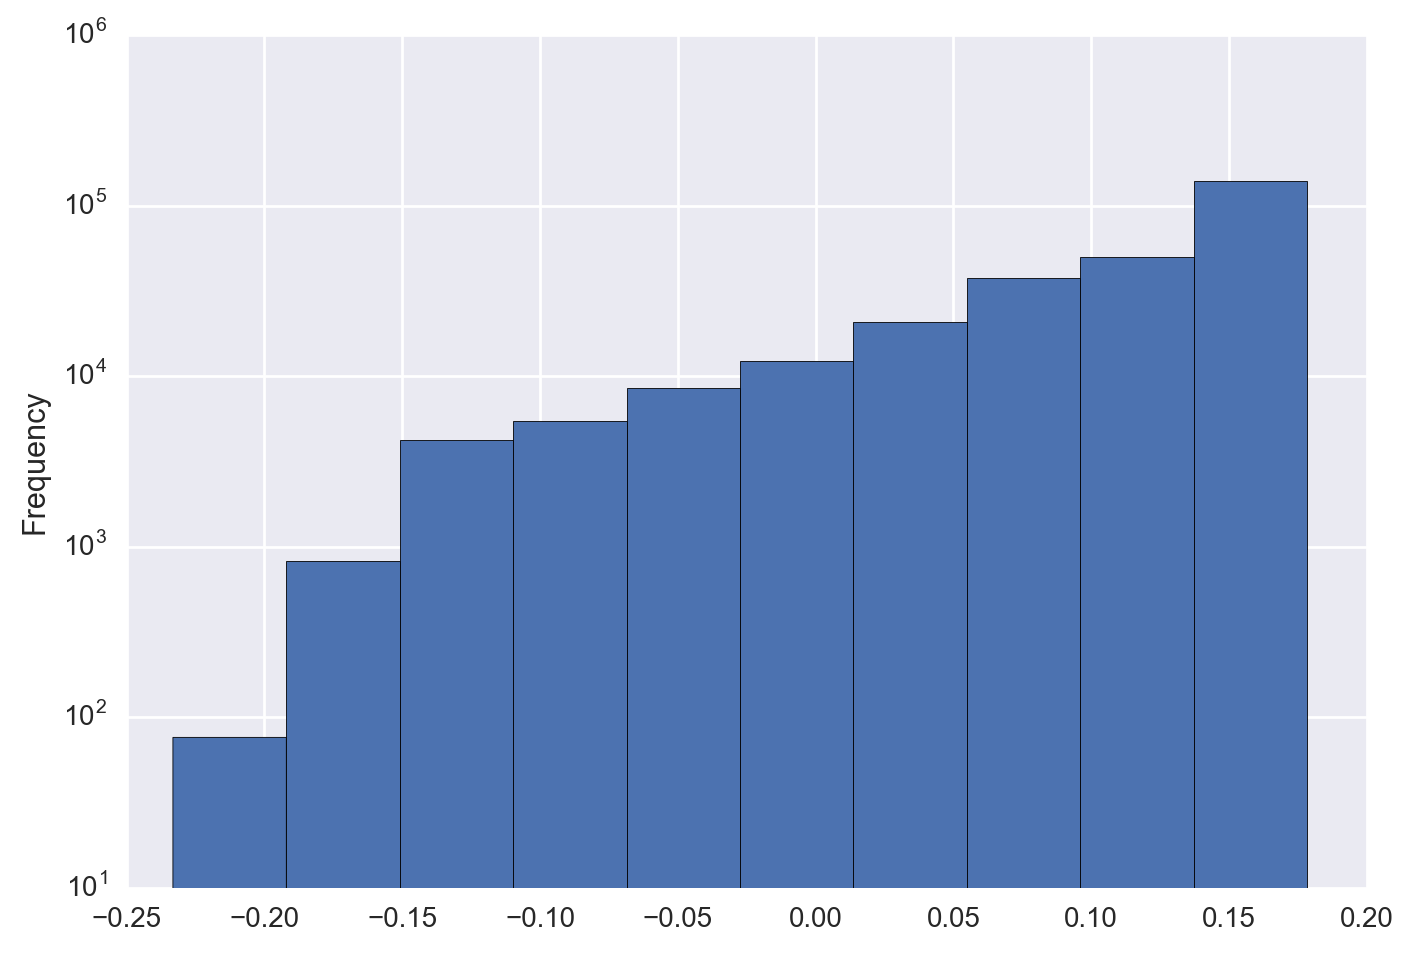

In [20]:
ax = training['score'].plot.hist()
ax.set_yscale('log')

training[['score']].describe()

## Model validation

In [21]:
validation.groupby('changeset_harmful').size()

changeset_harmful
-1    46681
 1    22765
dtype: int64

In [22]:
vX = validation.drop(non_training_attributes, axis=1)
vy = validation['changeset_harmful']

In [23]:
validation['prediction'] = model.predict(vX)
validation['score'] = model.decision_function(vX)

validation.to_csv(labelled_path + 'validation-review.csv', index=False)

In [24]:
matrix = confusion_matrix(vy, validation['prediction'])
matrix = pd.DataFrame(matrix, index=['Labelled harmful', 'Labelled good'], columns=['Predicted harmful', 'Predicted good'])
matrix

,Predicted harmful,Predicted good
Labelled harmful,8470,38211
Labelled good,2232,20533


In [25]:
report = classification_report(vy, validation['prediction'])
print(report)

             precision    recall  f1-score   support

         -1       0.79      0.18      0.30     46681
          1       0.35      0.90      0.50     22765

avg / total       0.65      0.42      0.36     69446



,score
count,69446.00
mean,0.10
std,0.08
min,-0.22
25%,0.06
50%,0.11
75%,0.17
max,0.18


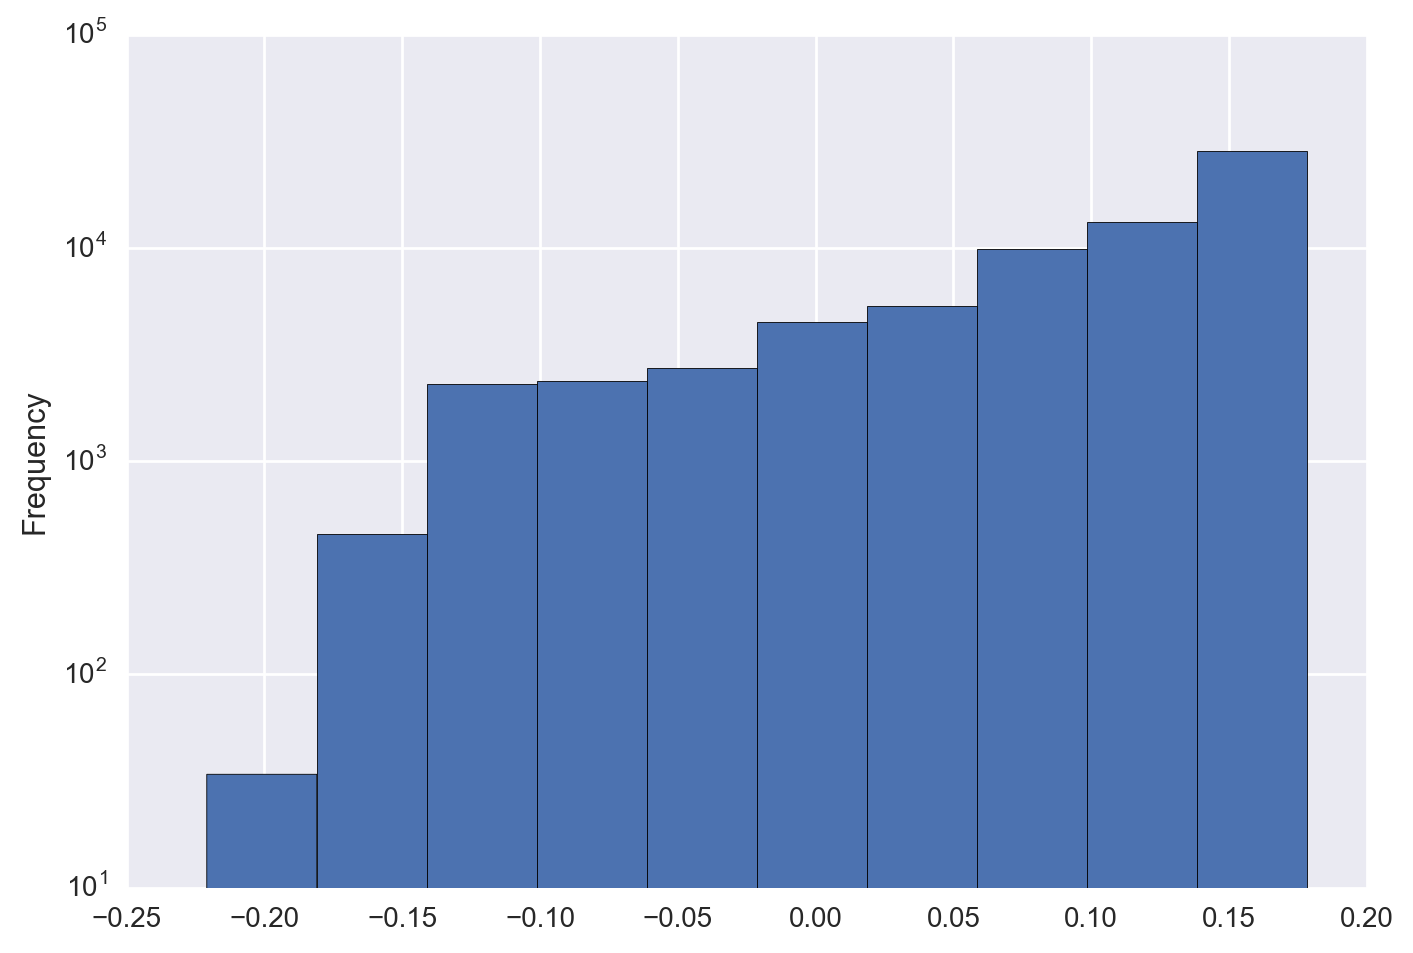

In [26]:
ax = validation['score'].plot.hist()
ax.set_yscale('log')

validation[['score']].describe()

## Model testing

In [27]:
unlabelled_path = testing_path = '../downloads/anomaly-detection/unlabelled/'

In [28]:
unlabelled = pd.read_csv(unlabelled_path + 'attributes.csv')
print(unlabelled.shape)
unlabelled.sample(10)

(288, 15)


,changeset_id,changeset_harmful,feature_id,feature_type,action_create,action_modify,action_delete,feature_version,highway_tag_created,highway_tag_deleted,highway_value_difference,primary_tags_difference,area_of_feature_bbox,length_of_longest_segment,feature_name_touched
9,49180282,NaN,497451997,way,0,1,0,3,0,0,0,0,37445.69,0.27,0
256,49171711,NaN,412457723,way,0,1,0,2,0,0,0,0,29823.52,0.25,0
61,49177918,NaN,333342921,way,0,1,0,3,0,0,0,0,3543.21,0.06,0
185,49173264,NaN,31862259,way,0,1,0,5,0,0,0,0,7832.68,0.08,0
66,49177815,NaN,1657992650,node,0,1,0,4,0,0,0,0,0.00,0.00,0
23,49179533,NaN,255803613,way,0,1,0,3,0,0,0,1,1172.73,0.00,0
217,49172420,NaN,162275052,way,0,1,0,12,0,0,-25,0,571.69,0.05,0
140,49175061,NaN,976875261,node,0,0,1,2,0,15,0,-1,0.00,0.00,0
115,49176051,NaN,31798061,way,0,1,0,9,0,0,0,0,226049.24,0.08,0
35,49179054,NaN,322701935,way,0,1,0,3,0,0,0,0,1590.82,0.03,0


In [29]:
# Drop all duplicate samples.
print('Shape before dropping duplicates: {}'.format(unlabelled.shape))
unlabelled = unlabelled.drop_duplicates(subset=['changeset_id', 'feature_id'])
print('Shape after dropping duplicates: {}'.format(unlabelled.shape))

Shape before dropping duplicates: (288, 15)
Shape after dropping duplicates: (288, 15)


In [30]:
# Using all of the unlabelled dataset for testing.
testing = unlabelled.sample(unlabelled.shape[0])

In [31]:
testing.describe()

,changeset_id,changeset_harmful,feature_id,action_create,action_modify,action_delete,feature_version,highway_tag_created,highway_tag_deleted,highway_value_difference,primary_tags_difference,area_of_feature_bbox,length_of_longest_segment,feature_name_touched
count,2.88e+02,0.0,2.88e+02,288.00,288.00,288.00,288.00,288.00,288.00,288.00,288.00,2.88e+02,288.00,288.00
mean,4.92e+07,NaN,5.11e+08,0.04,0.95,0.01,4.67,1.65,1.28,-0.89,0.06,2.69e+06,0.11,0.01
std,2.88e+03,NaN,1.02e+09,0.19,0.22,0.12,3.92,6.43,6.26,4.67,0.37,2.57e+07,0.26,0.12
min,4.92e+07,NaN,4.31e+06,0.00,0.00,0.00,1.00,0.00,0.00,-35.00,-1.00,0.00e+00,0.00,0.00
25%,4.92e+07,NaN,1.03e+08,0.00,1.00,0.00,2.00,0.00,0.00,0.00,0.00,4.09e+02,0.02,0.00
50%,4.92e+07,NaN,3.05e+08,0.00,1.00,0.00,3.00,0.00,0.00,0.00,0.00,4.57e+03,0.05,0.00
75%,4.92e+07,NaN,4.54e+08,0.00,1.00,0.00,5.00,0.00,0.00,0.00,0.00,3.82e+04,0.10,0.00
max,4.92e+07,NaN,4.89e+09,1.00,1.00,1.00,28.00,41.00,37.00,16.00,2.00,4.04e+08,3.02,1.00


In [32]:
testing.sum(numeric_only=True)

changeset_id                 1.42e+10
changeset_harmful            0.00e+00
feature_id                   1.47e+11
action_create                1.10e+01
action_modify                2.73e+02
action_delete                4.00e+00
feature_version              1.34e+03
highway_tag_created          4.74e+02
highway_tag_deleted          3.70e+02
highway_value_difference    -2.57e+02
primary_tags_difference      1.70e+01
area_of_feature_bbox         7.75e+08
length_of_longest_segment    3.24e+01
feature_name_touched         4.00e+00
dtype: float64

In [33]:
tX = testing.drop(non_training_attributes, axis=1)
ty = testing['changeset_harmful']

In [34]:
testing['prediction'] = model.predict(tX)
testing['score'] = model.decision_function(tX)

testing.to_csv(unlabelled_path + 'testing-review.csv', index=False)

In [35]:
tharmful_count = testing[testing['prediction'] == -1].shape[0]
tnot_harmful_count = testing[testing['prediction'] == 1].shape[0]

print('Predicted good: {}'.format(tnot_harmful_count))
print('Predicted harmful: {}'.format(tharmful_count))

print('Percentage harmful: {}%'.format(round(100.0 * tharmful_count / testing.shape[0], 2)))

Predicted good: 269
Predicted harmful: 19
Percentage harmful: 6.6%


,score
count,288.00
mean,0.14
std,0.06
min,-0.12
25%,0.11
50%,0.17
75%,0.17
max,0.18


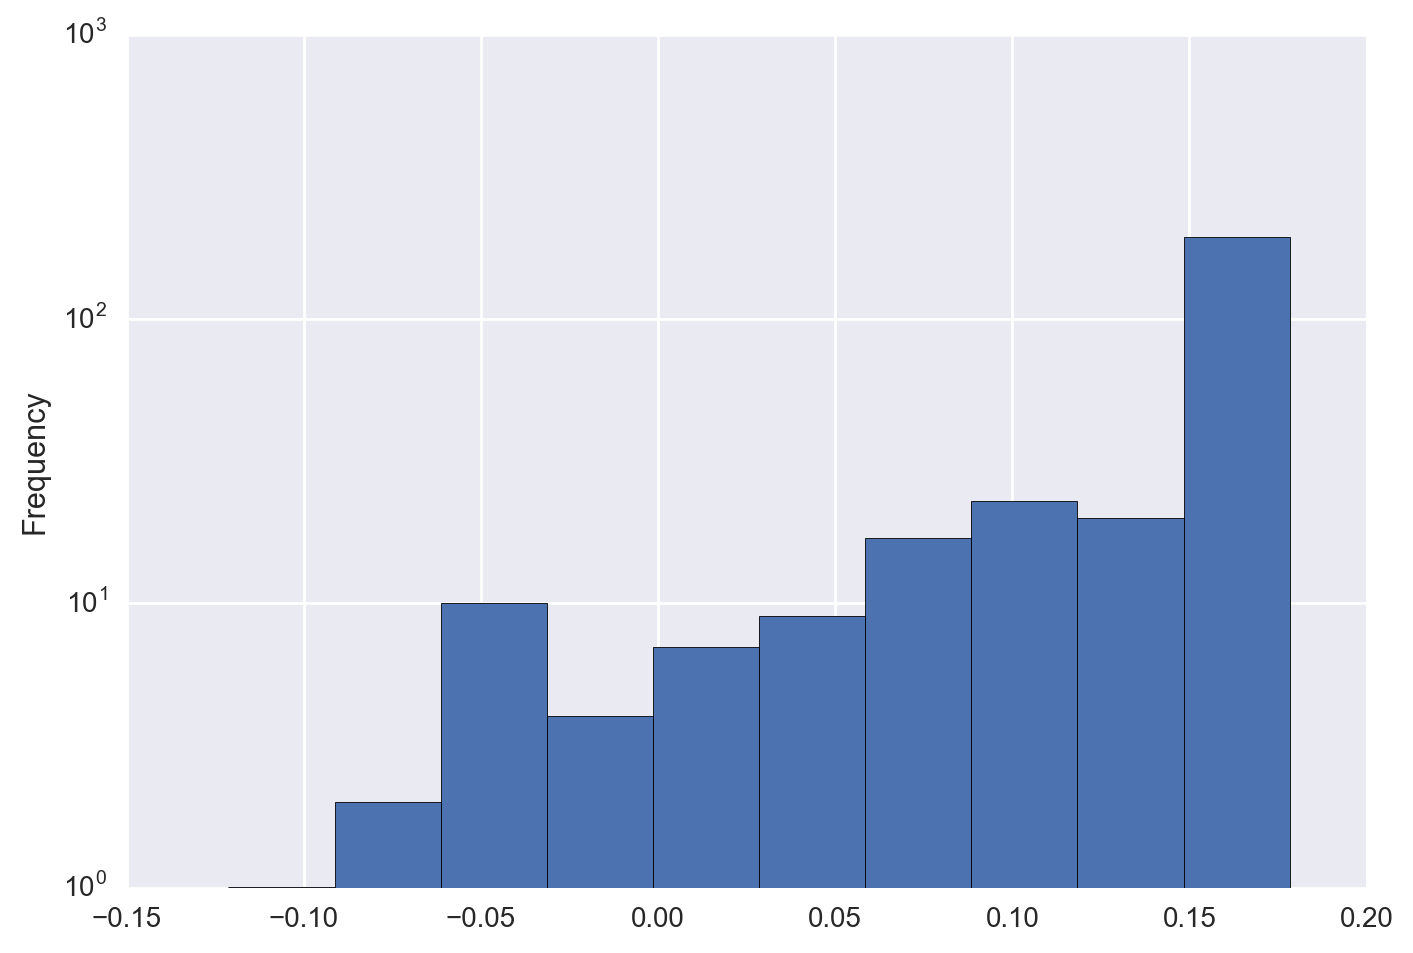

In [36]:
ax = testing['score'].plot.hist()
ax.set_yscale('log')

testing[['score']].describe()